## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
# Re-download data and format like last time:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import scipy.stats as stats

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

header_titles = ['party',
                 'handicapped-infants',
                 'water-project-cost-sharing',
                 'adoption-of-the-budget-resolution',
                 'physician-fee-freeze',
                 'el-salvador-aid',
                 'religious-groups-in-schools',
                 'anti-satellite-test-ban',
                 'aid-to-nicaraguan-contras',
                 'mx-missile',
                 'immigration',
                 'synfuels-corporation-cutback',
                 'education-spending',
                 'superfund-right-to-sue',
                 'crime',
                 'duty-free-exports',
                 'export-administration-act-south-africa']

df = pd.read_csv(url, names=header_titles, na_values='?')
df = df.replace({'y':1, 'n':0})
rep = df[df['party']=='republican']
dem = df[df['party'] =='democrat']

In [152]:
# Create function to calculate confidence interval

def confidence_interval(data, confidence=0.95):
  data = np.array(data.dropna()) # Make sure to drop NaN values!
  mean = np.mean(data)
  n = len(data)
  s = np.std(data, ddof=1)
  stderr = s / np.sqrt(n)
  margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, margin_of_error)

for header in header_titles[1:]:
    print(header + ":")
    mean_value, margin_of_error = confidence_interval(rep[header])
    print("Republican support: " 
          + str(round(mean_value *100, 1)) 
          + "%  ± " 
          + str(round(margin_of_error * 100, 2))
          + "%"
          )
    mean_value, margin_of_error = confidence_interval(dem[header])
    print("Democrat support: " 
          + str(round(mean_value *100, 1)) 
          + "% ± " 
          + str(round(margin_of_error * 100, 2))
          + "%"
          )
    print("")

handicapped-infants:
Republican support: 18.8%  ± 6.02%
Democrat support: 60.5% ± 6.01%

water-project-cost-sharing:
Republican support: 50.7%  ± 8.15%
Democrat support: 50.2% ± 6.38%

adoption-of-the-budget-resolution:
Republican support: 13.4%  ± 5.27%
Democrat support: 88.8% ± 3.85%

physician-fee-freeze:
Republican support: 98.8%  ± 1.69%
Democrat support: 5.4% ± 2.77%

el-salvador-aid:
Republican support: 95.2%  ± 3.31%
Democrat support: 21.6% ± 5.08%

religious-groups-in-schools:
Republican support: 89.8%  ± 4.66%
Democrat support: 47.7% ± 6.14%

anti-satellite-test-ban:
Republican support: 24.1%  ± 6.65%
Democrat support: 77.2% ± 5.14%

aid-to-nicaraguan-contras:
Republican support: 15.3%  ± 5.69%
Democrat support: 82.9% ± 4.58%

mx-missile:
Republican support: 11.5%  ± 4.92%
Democrat support: 75.8% ± 5.37%

immigration:
Republican support: 55.8%  ± 7.66%
Democrat support: 47.1% ± 6.07%

synfuels-corporation-cutback:
Republican support: 13.2%  ± 5.32%
Democrat support: 50.6% ± 6

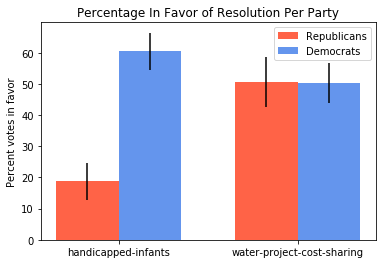

In [153]:
# Try to graphically show some of this information. 
# Trying to do something like this: 
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py


labels = header_titles[1:3]  # Only doing the first few lables so we can fit them in a graph.
rep_means = []
rep_error = []
dem_means = []
dem_error = []

for header in labels:
    x, y = confidence_interval(rep[header])
    rep_means.append(x*100)
    rep_error.append(y*100)
    x, y = confidence_interval(dem[header])
    dem_means.append(x*100)
    dem_error.append(y*100)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rep_means, width, yerr=rep_error, label='Republicans', color='tomato')
rects2 = ax.bar(x + width/2, dem_means, width, yerr=dem_error, label='Democrats', color='cornflowerblue')

ax.set_ylabel('Percent votes in favor')
ax.set_title('Percentage In Favor of Resolution Per Party')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend();

In [154]:
# Do chi test on poker data:

poker_training_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data'

column_headers = ["Suit of card 1", "Rank of card 1", "Suit of card 2", 
                  "Rank of card 2", "Suit of card 3", "Rank of card 3",
                  "Suit of card 4", "Rank of card 4", "Suit of card 5",
                  "Rank of card 5", "Poker Hand"]

df = pd.read_csv(poker_training_data, names=column_headers)
df.head()

,Suit of card 1,Rank of card 1,Suit of card 2,Rank of card 2,Suit of card 3,Rank of card 3,Suit of card 4,Rank of card 4,Suit of card 5,Rank of card 5,Poker Hand
0,1,10,1,11,1,13,1,12,1,1,9
1,2,11,2,13,2,10,2,12,2,1,9
2,3,12,3,11,3,13,3,10,3,1,9
3,4,10,4,11,4,1,4,13,4,12,9
4,4,1,4,13,4,12,4,11,4,10,9


In [155]:
# Get crosstab data:

table = pd.crosstab(df['Suit of card 1'],df['Rank of card 1'])
table

Rank of card 1,1,2,3,4,5,6,7,8,9,10,11,12,13
Suit of card 1,,,,,,,,,,,,,
1,455,474,474,460,466,455,476,524,462,479,488,464,473
2,505,477,460,449,495,462,509,488,521,448,511,491,482
3,493,503,467,514,482,457,470,464,473,484,478,475,490
4,529,487,481,496,449,486,506,472,511,466,449,510,470


In [156]:
table = np.array(table)
print(table)

[[455 474 474 460 466 455 476 524 462 479 488 464 473]
 [505 477 460 449 495 462 509 488 521 448 511 491 482]
 [493 503 467 514 482 457 470 464 473 484 478 475 490]
 [529 487 481 496 449 486 506 472 511 466 449 510 470]]


In [0]:
# Having problems figuring out how to calculate this equation by hand...

In [157]:
# Calculate with scipy.stats:
chi_2_stat, p_value, dof, expected = stats.chi2_contingency(table)
print("Chi^2 Statistic: " + str(chi_2_stat))
print("p value: " + str(p_value))

Chi^2 Statistic: 34.988809163056914
p value: 0.5165315608157963


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)